Article: https://www.embedded-robotics.com/machine-learning-text-classification/\
Code: Text Classification using TfIdf Vectorization\
Prepared By: Awais Naeem (awais.naeem@embedded-robotics.com)\
Copyrights: www.embedded-robotics.com\
Disclaimer: This code can be distributed with the proper mention of the owner copyrights

In [1]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [2]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/awais.naeem@ebryx.com/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/awais.naeem@ebryx.com/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/awais.naeem@ebryx.com/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/awais.naeem@ebryx.com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/awais.naeem@ebryx.com/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Disaster Tweets Data: https://www.kaggle.com/competitions/nlp-getting-started/data

In [3]:
data = pd.read_csv("train.csv")
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
data = data.drop(['id', 'keyword', 'location'], axis=1)

### Exploratory Data Analysis

In [5]:
data['word_count'] = data['text'].apply(lambda x: len(str(x).split(' ')))
avg_words_disaster_tweets = data[data['target'] == 1]['word_count'].mean()
avg_words_non_disaster_tweets = data[data['target'] == 0]['word_count'].mean()
print('Average Words in Disaster Tweets:', avg_words_disaster_tweets)
print('Average Words in Non-Disaster Tweets:', avg_words_non_disaster_tweets)

Average Words in Disaster Tweets: 15.20116172424335
Average Words in Non-Disaster Tweets: 14.723859972362966


In [6]:
data['char_count'] = data['text'].apply(lambda x: len(str(x)))
avg_char_disaster_tweets = data[data['target'] == 1]['char_count'].mean()
avg_char_non_disaster_tweets = data[data['target'] == 0]['char_count'].mean()
print('Average Characters in Disaster Tweets:', avg_char_disaster_tweets)
print('Average Characters in Non-Disaster Tweets:', avg_char_non_disaster_tweets)

Average Characters in Disaster Tweets: 108.11342097217977
Average Characters in Non-Disaster Tweets: 95.70681713496084


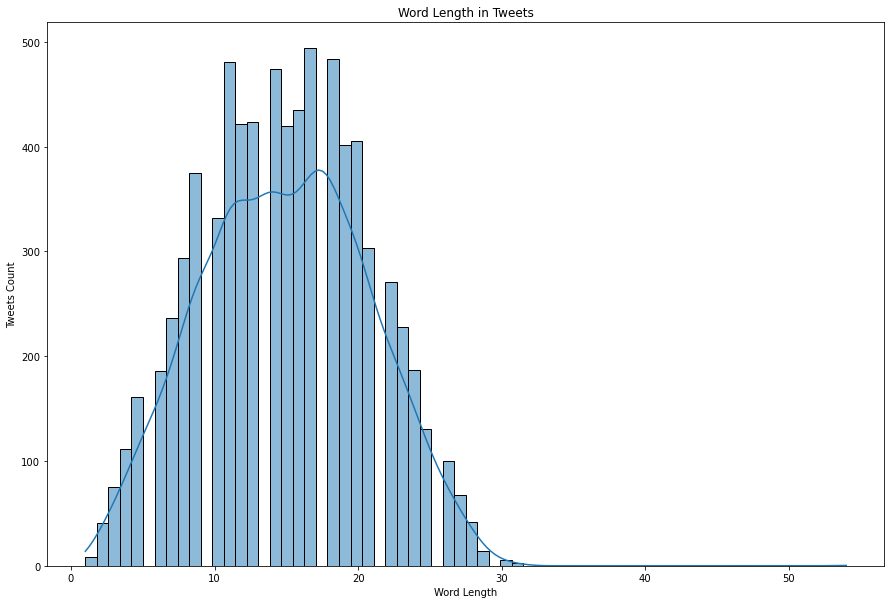

In [7]:
plt.figure(figsize=(15,10))
sns.histplot(data=data, x='word_count', kde=True)
plt.title('Word Length in Tweets')
plt.xlabel('Word Length')
plt.ylabel('Tweets Count')
plt.show()

In [8]:
data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

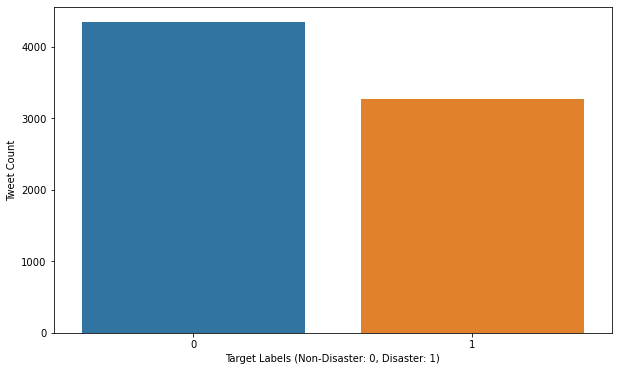

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='target')
plt.xlabel('Target Labels (Non-Disaster: 0, Disaster: 1)')
plt.ylabel('Tweet Count')
plt.show()

### Data Cleaning and Pre-processing:
1. Remove pre and post spaces
2. Lower the case of tweet's text
3. Remove URLS
4. Remove Numbers 
5. Remove punctuation and special characters
6. Remove Stopwords
7. Word Lemmatization
8. Downscaling to balance Disaster and Non-Disaster Tweets

In [10]:
def clean_text (text):
    # Remove pre and post spaces
    text = str(text).strip()
    
    # Lower the text case
    text = str(text).lower()
    
    # Remove URL from text
    text = re.sub(r"\s+http\S+", r"", text)

    # Remove Numbers from text
    text = re.sub(r"\d+", r"", text)
    
    # Tokenize the sentences into individual words with punctuations and special characters treated as separate tokens
    word_tokens = word_tokenize(text)
    
    # Remove punctuation and special characters
    word_tokens = [word for word in word_tokens if word.isalpha()]
    
    # Generate the stop words for english language
    stop_words = stopwords.words('english')

    # Remove stopwords
    word_tokens = [word for word in word_tokens if word not in stop_words]
    
    return word_tokens
    

In [11]:
def get_wordnet_pos (tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [12]:
def lemmatize (word_list):
    wl = WordNetLemmatizer()
    word_pos_tags = pos_tag(word_list)
    lemmatized_list = []
    for tag in word_pos_tags:
        lemmatize_word = wl.lemmatize(tag[0],get_wordnet_pos(tag[1]))
        lemmatized_list.append(lemmatize_word)
    return " ".join(lemmatized_list)

In [13]:
data['text'] = data['text'].apply(lambda str: clean_text(str))

In [14]:
data['text'] = data['text'].apply(lambda str: lemmatize(str))

In [19]:
data_X = data['text'].tolist()
data_y = data['target'].tolist()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=0, shuffle=True)
print("X_train:", len(X_train))
print("X_test:", len(X_test))
print("y_train:", len(y_train))
print("y_test:", len(y_test))

X_train: 6090
X_test: 1523
y_train: 6090
y_test: 1523


In [21]:
count_vectorizer = CountVectorizer(analyzer = 'word', min_df = 10, max_df = 0.9)
X_train = count_vectorizer.fit_transform(X_train)
X_test = count_vectorizer.transform(X_test)

In [22]:
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

### Training and Evaluating Machine Learning Models

In [23]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [24]:
lr_y_pred = lr_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, lr_y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, lr_y_pred))
print('Classification Report:\n', classification_report(y_test, lr_y_pred))

Accuracy Score: 0.7905449770190414
Confusion Matrix:
 [[782 104]
 [215 422]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.83       886
           1       0.80      0.66      0.73       637

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.79      1523



In [26]:
svm_model = SVC(C=1, kernel='rbf')
svm_model.fit(X_train, y_train)

SVC(C=1)

In [27]:
svm_y_pred = svm_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, svm_y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, svm_y_pred))
print('Classification Report:\n', classification_report(y_test, svm_y_pred))

Accuracy Score: 0.7931713722915299
Confusion Matrix:
 [[794  92]
 [223 414]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.83       886
           1       0.82      0.65      0.72       637

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523



In [30]:
rf_model = RandomForestClassifier(n_estimators=1000)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [31]:
rf_y_pred = rf_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, rf_y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, rf_y_pred))
print('Classification Report:\n', classification_report(y_test, rf_y_pred))

Accuracy Score: 0.7728168089297439
Confusion Matrix:
 [[746 140]
 [206 431]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81       886
           1       0.75      0.68      0.71       637

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



In [37]:
gb_model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=500)

In [38]:
gb_y_pred = gb_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, gb_y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, gb_y_pred))
print('Classification Report:\n', classification_report(y_test, gb_y_pred))

Accuracy Score: 0.7669074195666448
Confusion Matrix:
 [[789  97]
 [258 379]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.89      0.82       886
           1       0.80      0.59      0.68       637

    accuracy                           0.77      1523
   macro avg       0.77      0.74      0.75      1523
weighted avg       0.77      0.77      0.76      1523

